In [9]:
# Standard libraries
import json
import os
import pickle
import random

# Data manipulation and linear algebra
import numpy as np
import pandas as pd

# Machine Learning and Neural Networks
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import (Compose, Normalize, RandomAffine, RandomApply, RandomHorizontalFlip,
                                    RandomResizedCrop, RandomRotation, Resize, ToTensor)
from torch.utils.data import DataLoader, Dataset, Subset

# Image processing
from PIL import Image
import cv2
import timm
from transformers import ViTForImageClassification, ViTImageProcessor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [10]:
# load in the D:\glaucoma_datasets\SMDG-19\metadata - standardized.csv as a pandas dataframe
import pandas as pd

# load in the metadata
df = pd.read_csv(r'D:\glaucoma\data\raw\SMDG-19\metadata - standardized.csv')
df.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# print the columns
print(df.columns)

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')


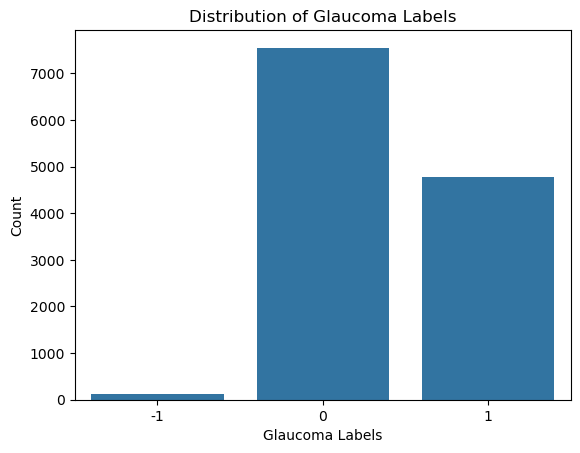

[ 0  1 -1]
[0 1]


In [12]:
# plot the 'types' column (glaucoma labels)
sns.countplot(x='types', data=df)
plt.title('Distribution of Glaucoma Labels')
plt.xlabel('Glaucoma Labels')
plt.ylabel('Count')
plt.show()
# print the unique values in the 'types' column
print(df['types'].unique())
# drop all the -1 types values from the df
df = df[df['types'] != -1]
# print the unique values in the 'types' column
print(df['types'].unique())

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import json
from datetime import datetime

# Modified U-Net for multi-task segmentation
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class MultiTaskUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):  # n_classes=2 for OC and OD
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (shared)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder for Optic Cup
        self.up1_oc = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1_oc = DoubleConv(1024, 512)
        self.up2_oc = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2_oc = DoubleConv(512, 256)
        self.up3_oc = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3_oc = DoubleConv(256, 128)
        self.up4_oc = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4_oc = DoubleConv(128, 64)
        self.outc_oc = nn.Conv2d(64, 1, kernel_size=1)
        
        # Decoder for Optic Disc
        self.up1_od = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1_od = DoubleConv(1024, 512)
        self.up2_od = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2_od = DoubleConv(512, 256)
        self.up3_od = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3_od = DoubleConv(256, 128)
        self.up4_od = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4_od = DoubleConv(128, 64)
        self.outc_od = nn.Conv2d(64, 1, kernel_size=1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Shared encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Optic Cup decoder
        x_oc = self.up1_oc(x5)
        x_oc = self.up_conv1_oc(torch.cat([x4, x_oc], dim=1))
        x_oc = self.up2_oc(x_oc)
        x_oc = self.up_conv2_oc(torch.cat([x3, x_oc], dim=1))
        x_oc = self.up3_oc(x_oc)
        x_oc = self.up_conv3_oc(torch.cat([x2, x_oc], dim=1))
        x_oc = self.up4_oc(x_oc)
        x_oc = self.up_conv4_oc(torch.cat([x1, x_oc], dim=1))
        x_oc = self.outc_oc(x_oc)
        oc_mask = self.sigmoid(x_oc)
        
        # Optic Disc decoder
        x_od = self.up1_od(x5)
        x_od = self.up_conv1_od(torch.cat([x4, x_od], dim=1))
        x_od = self.up2_od(x_od)
        x_od = self.up_conv2_od(torch.cat([x3, x_od], dim=1))
        x_od = self.up3_od(x_od)
        x_od = self.up_conv3_od(torch.cat([x2, x_od], dim=1))
        x_od = self.up4_od(x_od)
        x_od = self.up_conv4_od(torch.cat([x1, x_od], dim=1))
        x_od = self.outc_od(x_od)
        od_mask = self.sigmoid(x_od)
        
        return oc_mask, od_mask

# Enhanced dataset class for both OC and OD masks
class FundusMultiTaskDataset(Dataset):
    def __init__(self, df, base_path, transform=None):
        self.df = df
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image name from the path
        fundus_name = self.df.iloc[idx]['fundus'].split('/')[-1]
        oc_mask_name = self.df.iloc[idx]['fundus_oc_seg'].split('/')[-1]
        od_mask_name = self.df.iloc[idx]['fundus_od_seg'].split('/')[-1]
        
        # Construct full paths using the correct directory structure
        fundus_path = os.path.join(self.base_path, 'full-fundus', 'full-fundus', fundus_name)
        oc_mask_path = os.path.join(self.base_path, 'optic-cup', 'optic-cup', oc_mask_name)
        od_mask_path = os.path.join(self.base_path, 'optic-disc', 'optic-disc', od_mask_name)

        # Load images
        image = Image.open(fundus_path).convert('RGB')
        oc_mask = Image.open(oc_mask_path).convert('L')
        od_mask = Image.open(od_mask_path).convert('L')

        # Apply transforms
        if self.transform:
            image = self.transform(image)
            oc_mask = self.transform(oc_mask)
            od_mask = self.transform(od_mask)

        return image, oc_mask, od_mask

# Combined loss function
def multi_task_dice_loss(pred_oc, target_oc, pred_od, target_od, alpha=0.5):
    smooth = 1e-5
    
    # Dice loss for optic cup
    intersection_oc = (pred_oc * target_oc).sum()
    dice_oc = 1 - ((2. * intersection_oc + smooth) / (pred_oc.sum() + target_oc.sum() + smooth))
    
    # Dice loss for optic disc
    intersection_od = (pred_od * target_od).sum()
    dice_od = 1 - ((2. * intersection_od + smooth) / (pred_od.sum() + target_od.sum() + smooth))
    
    # Weighted sum of both losses
    return alpha * dice_oc + (1 - alpha) * dice_od, dice_oc.item(), dice_od.item()

# Enhanced training function for multi-task learning
def train_multi_task_model(model, train_loader, val_loader, device, alpha=0.5, num_epochs=100, 
                           continue_from=None, log_dir='training_logs'):
    # Create log directory if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)
    
    # Initialize or load model state
    start_epoch = 0
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_oc_losses = []
    train_od_losses = []
    val_oc_losses = []
    val_od_losses = []
    
    if continue_from and os.path.exists(continue_from):
        print(f"Loading model state from {continue_from}")
        checkpoint = torch.load(continue_from)
        
        # Handle checkpoint format
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint.get('epoch', 0)
            best_val_loss = checkpoint.get('best_val_loss', float('inf'))
            # Load history if available
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            train_oc_losses = checkpoint.get('train_oc_losses', [])
            train_od_losses = checkpoint.get('train_od_losses', [])
            val_oc_losses = checkpoint.get('val_oc_losses', [])
            val_od_losses = checkpoint.get('val_od_losses', [])
        else:
            # Legacy format (just model state)
            model.load_state_dict(checkpoint)
            
        print(f"Continuing training from epoch {start_epoch}")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Create log file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f'training_log_{timestamp}.txt')
    
    # Log initial info
    with open(log_file, 'w') as f:
        f.write("Multi-Task Training Started\n")
        f.write("=" * 100 + "\n")
        f.write(f"{'Epoch':^6} | {'Batch':^12} | {'Train Loss':^12} | {'OC Loss':^12} | {'OD Loss':^12} | {'Val Loss':^12} | {'Val OC':^12} | {'Val OD':^12} | {'Best':^6}\n")
        f.write("-" * 100 + "\n")
    
    print("\nMulti-Task Training Started")
    print("=" * 100)
    print(f"{'Epoch':^6} | {'Batch':^12} | {'Train Loss':^12} | {'OC Loss':^12} | {'OD Loss':^12} | {'Val Loss':^12} | {'Val OC':^12} | {'Val OD':^12} | {'Best':^6}")
    print("-" * 100)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_oc_loss = 0
        train_od_loss = 0
        
        for batch_idx, (images, oc_masks, od_masks) in enumerate(train_loader):
            images = images.to(device)
            oc_masks = oc_masks.to(device)
            od_masks = od_masks.to(device)
            
            optimizer.zero_grad()
            oc_outputs, od_outputs = model(images)
            
            loss, oc_loss, od_loss = multi_task_dice_loss(
                oc_outputs, oc_masks, od_outputs, od_masks, alpha=alpha
            )
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_oc_loss += oc_loss
            train_od_loss += od_loss
            
            # Print batch progress
            if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
                current_train_loss = train_loss / (batch_idx + 1)
                current_oc_loss = train_oc_loss / (batch_idx + 1)
                current_od_loss = train_od_loss / (batch_idx + 1)
                
                batch_log = f"{epoch+1:^6d} | {f'{batch_idx+1}/{len(train_loader)}':^12} | {current_train_loss:^12.4f} | {current_oc_loss:^12.4f} | {current_od_loss:^12.4f} | {'---':^12} | {'---':^12} | {'---':^12} | {'':^6}"
                print(batch_log, end='\r')
                with open(log_file, 'a') as f:
                    f.write(batch_log + '\n')

        # Validation
        model.eval()
        val_loss = 0
        val_oc_loss = 0
        val_od_loss = 0
        
        with torch.no_grad():
            for images, oc_masks, od_masks in val_loader:
                images = images.to(device)
                oc_masks = oc_masks.to(device)
                od_masks = od_masks.to(device)
                
                oc_outputs, od_outputs = model(images)
                
                batch_loss, oc_loss, od_loss = multi_task_dice_loss(
                    oc_outputs, oc_masks, od_outputs, od_masks, alpha=alpha
                )
                
                val_loss += batch_loss.item()
                val_oc_loss += oc_loss
                val_od_loss += od_loss

        # Average losses
        train_loss /= len(train_loader)
        train_oc_loss /= len(train_loader)
        train_od_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_oc_loss /= len(val_loader)
        val_od_loss /= len(val_loader)
        
        # Append to history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_oc_losses.append(train_oc_loss)
        train_od_losses.append(train_od_loss)
        val_oc_losses.append(val_oc_loss)
        val_od_losses.append(val_od_loss)

        # Check if this is the best model
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss
            # Save checkpoint
            save_path = os.path.join(log_dir, 'best_multitask_model.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_oc_losses': train_oc_losses,
                'train_od_losses': train_od_losses,
                'val_oc_losses': val_oc_losses,
                'val_od_losses': val_od_losses,
                'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
            }
            torch.save(checkpoint, save_path)

        # Log progress with epoch summary
        log_line = f"{epoch+1:^6d} | {'Complete':^12} | {train_loss:^12.4f} | {train_oc_loss:^12.4f} | {train_od_loss:^12.4f} | {val_loss:^12.4f} | {val_oc_loss:^12.4f} | {val_od_loss:^12.4f} | {'*' if is_best else ' ':^6}"
        print(log_line)
        with open(log_file, 'a') as f:
            f.write(log_line + '\n')

    print("=" * 100)
    final_msg = f"Training completed. Best validation loss: {best_val_loss:.4f}"
    print(final_msg)
    with open(log_file, 'a') as f:
        f.write("=" * 100 + '\n')
        f.write(final_msg + '\n')
    
    # Return all histories for plotting
    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_oc_loss': train_oc_losses,
        'train_od_loss': train_od_losses,
        'val_oc_loss': val_oc_losses,
        'val_od_loss': val_od_losses
    }

# Enhanced visualization function
def plot_training_history(history):
    plt.figure(figsize=(15, 10))
    
    # Plot combined losses
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Combined Train Loss')
    plt.plot(history['val_loss'], label='Combined Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Combined Training and Validation Loss')
    
    # Plot task-specific losses
    plt.subplot(2, 1, 2)
    plt.plot(history['train_oc_loss'], label='OC Train Loss')
    plt.plot(history['val_oc_loss'], label='OC Val Loss')
    plt.plot(history['train_od_loss'], label='OD Train Loss', linestyle='--')
    plt.plot(history['val_od_loss'], label='OD Val Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Task-Specific Training and Validation Loss')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Function to visualize predictions
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (images, oc_masks, od_masks) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            oc_preds, od_preds = model(images)
            
            # Move tensors to CPU for visualization
            images = images.cpu()
            oc_masks = oc_masks.cpu()
            od_masks = od_masks.cpu()
            oc_preds = oc_preds.cpu()
            od_preds = od_preds.cpu()
            
            # Plot for each image in the batch
            for j in range(min(1, images.size(0))):  # Plot only first image in each batch
                plt.subplot(num_samples, 5, i*5 + 1)
                plt.imshow(images[j].permute(1, 2, 0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(num_samples, 5, i*5 + 2)
                plt.imshow(oc_masks[j].squeeze(), cmap='gray')
                plt.title('GT Optic Cup')
                plt.axis('off')
                
                plt.subplot(num_samples, 5, i*5 + 3)
                plt.imshow(oc_preds[j].squeeze(), cmap='gray')
                plt.title('Pred Optic Cup')
                plt.axis('off')
                
                plt.subplot(num_samples, 5, i*5 + 4)
                plt.imshow(od_masks[j].squeeze(), cmap='gray')
                plt.title('GT Optic Disc')
                plt.axis('off')
                
                plt.subplot(num_samples, 5, i*5 + 5)
                plt.imshow(od_preds[j].squeeze(), cmap='gray')
                plt.title('Pred Optic Disc')
                plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

In [14]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Load and prepare your DataFrame
base_path = r'D:\glaucoma\data\raw\SMDG-19\metadata - standardized.csv' 

# Remove rows with NaN in required columns and "Not Visible" values
df = df.dropna(subset=['fundus', 'fundus_oc_seg', 'fundus_od_seg'])
df = df[df['fundus_oc_seg'] != 'Not Visible']
df = df[df['fundus_od_seg'] != 'Not Visible']

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print dataset sizes
print(f'Train samples: {len(train_df)}')
print(f'Validation samples: {len(val_df)}')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets with both OC and OD masks
train_dataset = FundusMultiTaskDataset(train_df, base_path, transform=transform)
val_dataset = FundusMultiTaskDataset(val_df, base_path, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Initialize multi-task model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskUNet().to(device)

# Create log directory
log_dir = 'multitask_training_logs'
os.makedirs(log_dir, exist_ok=True)

# Set loss weighting parameter (alpha=0.5 gives equal weight to both tasks)
alpha = 0.5

# Train the model
history = train_multi_task_model(
    model, train_loader, val_loader, device, 
    alpha=alpha,
    num_epochs=100, 
    continue_from=None,  # Set to path if continuing from saved model
    log_dir=log_dir
)

# Plot detailed training history
plot_training_history(history)

# Visualize some predictions
visualize_predictions(model, val_loader, device, num_samples=3)

Train samples: 2244
Validation samples: 561

Multi-Task Training Started
Epoch  |    Batch     |  Train Loss  |   OC Loss    |   OD Loss    |   Val Loss   |    Val OC    |    Val OD    |  Best 
----------------------------------------------------------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\glaucoma\\data\\raw\\SMDG-19\\metadata - standardized.csv\\full-fundus\\full-fundus\\G1020-904.png'

In [ ]:
# Visualize results on validation set
model.eval()
with torch.no_grad():
    # Get a batch of validation images
    images, masks = next(iter(val_loader))
    images, masks = images.to(device), masks.to(device)
    
    # Get predictions
    preds = model(images)
    
    # Plot results for nine images
    fig, axes = plt.subplots(9, 3, figsize=(15, 45))  # Adjusted figure size for 9 rows
    
    for idx in range(min(9, len(images))):
        # Original image
        axes[idx, 0].imshow(images[idx].cpu().permute(1, 2, 0))
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        # Ground truth mask
        axes[idx, 1].imshow(masks[idx].cpu().squeeze(), cmap='gray')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        # Predicted mask
        axes[idx, 2].imshow(preds[idx].cpu().squeeze(), cmap='gray')
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')
    
    # Add column labels
    fig.suptitle('Validation Results: Original vs Ground Truth vs Prediction', y=0.92)
    axes[0, 0].set_title('Original Image', pad=20, fontsize=12)
    axes[0, 1].set_title('Ground Truth', pad=20, fontsize=12)
    axes[0, 2].set_title('Prediction', pad=20, fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# plot summury statistics of following columns: gender, age, eye, iop, vcdr,  'expert1_grade', 'expert2_grade', 'expert3_grade', 'expert4_grade', 'expert5_grade''cdr_avg', 'cdr_expert1','cdr_expert2', 'cdr_expert3', 'cdr_expert4
import matplotlib.pyplot as plt
import seaborn as sns

# Set of relevant columns
cols = ['gender', 'age', 'eye', 'iop', 'vcdr',
        'expert1_grade', 'expert2_grade', 'expert3_grade', 'expert4_grade', 'expert5_grade',
        'cdr_avg', 'cdr_expert1', 'cdr_expert2', 'cdr_expert3', 'cdr_expert4']

# Total number of rows in the dataset
total_rows = len(df)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# Loop through columns and plot each one
for i, col in enumerate(cols, 1):
    plt.subplot(5, 3, i)
    non_null_count = df[col].notnull().sum()
    title = f"{col} ({non_null_count}/{total_rows} filled)"
    
    if df[col].dtype == 'object' or df[col].nunique() < 10:
        # Categorical: countplot
        sns.countplot(data=df, x=col, order=df[col].dropna().value_counts().index)
        plt.xticks(rotation=45)
    else:
        # Numerical: histogram
        sns.histplot(df[col].dropna(), kde=True, bins=20)
    
    plt.title(title)
    plt.tight_layout()

plt.suptitle("Summary Statistics of Glaucoma Dataset (Filled Counts Included)", fontsize=16, y=1.02)
plt.show()

In [ ]:
df_airogs = pd.read_csv(r'D:\glaucoma_datasets\AIROGS\train_labels.csv')
df_airogs.head()

# path to the images is D:\glaucoma_datasets\AIROGS\img + challenge_id + .jpg
df_airogs['path'] = df_airogs['challenge_id'].apply(lambda x: os.path.join(r'D:\glaucoma_datasets\AIROGS\img', str(x) + '.jpg'))
# check the class distribution
df_airogs['class'].value_counts().plot(kind='bar')

In [ ]:
# PAPILLA dataset: already included in SMDG-19

In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, csv_file, image_dir='Images', transform=None, max_images=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.image_dir = image_dir
        self.transform = transform
        self.max_images = max_images
        
        if csv_file == "index.json":
            with open(os.path.join(root_dir, csv_file), 'r') as f:
                self.labels_dict = json.load(f)
            self.image_filenames = list(self.labels_dict.keys())
        elif csv_file == "metadata - standardized.csv":
            self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file)) 
            # Filter DataFrame based on labels
            self.labels_df = self.labels_df[self.labels_df['types'].isin([0, 1])]
            
            
            # Filter image_filenames based on labels
            self.image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if f.endswith('.png')]
            self.image_filenames = [f for f in self.image_filenames if f[:-4] in self.labels_df['names'].values]

 
        else:
            self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file))
            self.image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if f.endswith('.jpg')]
            
        
        self.image_filenames = self.image_filenames[:max_images] if max_images is not None else self.image_filenames

        print(f'Successfully loaded dataset with {len(self.image_filenames)} images.')

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_dir, self.image_filenames[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = Image.fromarray(img)  # Convert numpy array to PIL Image

        if self.transform:
            img = self.transform(img)
        if self.csv_file == 'metadata - standardized.csv':
            label = self.labels_df.loc[self.labels_df['names']+".png" == self.image_filenames[idx], 'types'].values[0]        
               
            
        label_tensor = torch.tensor(label, dtype=torch.long)

        
        return img, label_tensor

In [ ]:
train_transforms = Compose([
    Resize((512,512)),  # Slightly larger to allow for random crops
    RandomResizedCrop((312,312), scale=(0.8, 1.0)),  # Random scaling
    RandomHorizontalFlip(),
    RandomApply([RandomRotation(10)], p=0.5),
    RandomApply([RandomAffine(degrees=0, scale=(0.9, 1.1))], p=0.5),  # Random scaling
    Resize((312,312)),
    
    ToTensor(),
   Normalize(mean=[0.7538, 0.4848, 0.3553], std=[0.2417, 0.1874, 0.2076]),
])


# Define validation transformations without augmentation
val_transforms = Compose([
    Resize((312,312)),
    ToTensor(),
   Normalize(mean=[0.7538, 0.4848, 0.3553], std=[0.2417, 0.1874, 0.2076]),
])

In [ ]:
batch_size=32
num_classes = 2

smdg_csv_file='metadata - standardized.csv'
smdg_root_dir = r'D:\glaucoma_datasets\SMDG-19'
smdg_image_dir = r'full-fundus\full-fundus'

# check the number of files in the smdg_image_dir
smdg_image_files = os.listdir(os.path.join(smdg_root_dir, smdg_image_dir))
print(f"Number of files in {smdg_image_dir}: {len(smdg_image_files)}")


# Initialize the datasets with appropriate transformations
smdg_train_dataset = GlaucomaDataset(root_dir=smdg_root_dir, image_dir=smdg_image_dir,
                                csv_file=smdg_csv_file, transform=train_transforms)




smdg_val_dataset = GlaucomaDataset(root_dir=smdg_root_dir, image_dir=smdg_image_dir, 
                                      csv_file=smdg_csv_file, transform=val_transforms)



# Split dataset indices
smdg_train_indices, smdg_val_indices = train_test_split(range(len(smdg_train_dataset)), test_size=0.3, random_state=42)

# Create Subset for train and validation datasets
smdg_train_dataset = Subset(smdg_train_dataset, smdg_train_indices)
smdg_val_dataset = Subset(smdg_val_dataset, smdg_val_indices)



smdg_train_loader = DataLoader(smdg_train_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
smdg_val_loader = DataLoader(smdg_val_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

print("loaded smdg dataaset")

In [ ]:
train_loaders=[smdg_train_loader]

val_loaders=[smdg_val_loader]

dataset_name=["SMDG"]

# print the number of images in the train and validation datasets
print(f"Number of images in the train dataset: {len(smdg_train_dataset)}")
print(f"Number of images in the validation dataset: {len(smdg_val_dataset)}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=5, title="Dataset Samples"):
    # Create a figure with num_images rows and 1 column
    fig, axes = plt.subplots(num_images, 1, figsize=(8, 4*num_images))
    
    # Randomly select indices
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        
        # Convert the image tensor to numpy and transpose to (H,W,C)
        img_np = image.permute(1, 2, 0).numpy()
        
        # Normalize image for display if needed
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f'Label: {"Glaucoma" if label == 1 else "Normal"}')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display training samples
print("Training Dataset Samples:")
show_images(smdg_train_dataset, title="Training Dataset Samples")

# Display validation samples
print("\nValidation Dataset Samples:")
show_images(smdg_val_dataset, title="Validation Dataset Samples")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
from datetime import datetime
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=50, device='cuda'):
    
    # Create directory for checkpoints
    os.makedirs('checkpoints', exist_ok=True)
    
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_loop.set_postfix({
                'loss': loss.item(), 
                'acc': 100 * train_correct / train_total
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save checkpoint if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, f'checkpoints/best_model.pth')
            print(f'Saved new best model with validation loss: {val_loss:.4f}')
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')
        print('-' * 60)
    
    # Plot training history
    plot_training_history(history)
    return model, history

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = resnet50(weights='ResNet50_Weights.DEFAULT')
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify last layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model
model, history = train_model(model, smdg_train_loader, smdg_val_loader, criterion, 
                           optimizer, scheduler, num_epochs=10, device=device)